In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

#f = lambda x: 3*np.sin(0.6*x[..., 0]) * np.exp(-0.04*x[..., 0]**2)
observation_index_points = np.sort(np.random.uniform(-1., 1., 200))[..., np.newaxis].astype(np.float64)
#observations = np.random.normal(f(observation_index_points), .005).astype(np.float64)

iteration = 0
def joint_log_prob(index_points, predictions):   
    gp_predictions = tfd.GaussianProcess(
        kernel=psd_kernels.ExponentiatedQuadratic(
            np.float64(10.0),np.float64(2.5)),index_points=index_points, observation_noise_variance=np.float64(1e-4))
    logprob = gp_predictions.log_prob(predictions)
    #global iteration
    #print(iteration,logprob.numpy())
    #iteration+=1
    return logprob

parallel = 10
init_preds = 50*np.random.randn(parallel,200).astype(np.float64)
initial_chain_states = [
    init_preds,
]
unconstraining_bijectors = [
    tfp.bijectors.Identity()
]
def unnormalized_log_posterior(preds):
    return joint_log_prob(observation_index_points, preds)

iteration = 0
num_results = 300
num_burnin_steps = 300
kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            step_size=np.float64(0.01),
            num_leapfrog_steps=2)
kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8), target_accept_prob=np.float64(0.75))

from time import time
start = time()
[preds], kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_states,
    kernel=kernel)
print("Time: %0.2f" % (time()-start))
print("Acceptance rate: {}".format(
  np.mean(kernel_results.inner_results.is_accepted)))

/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


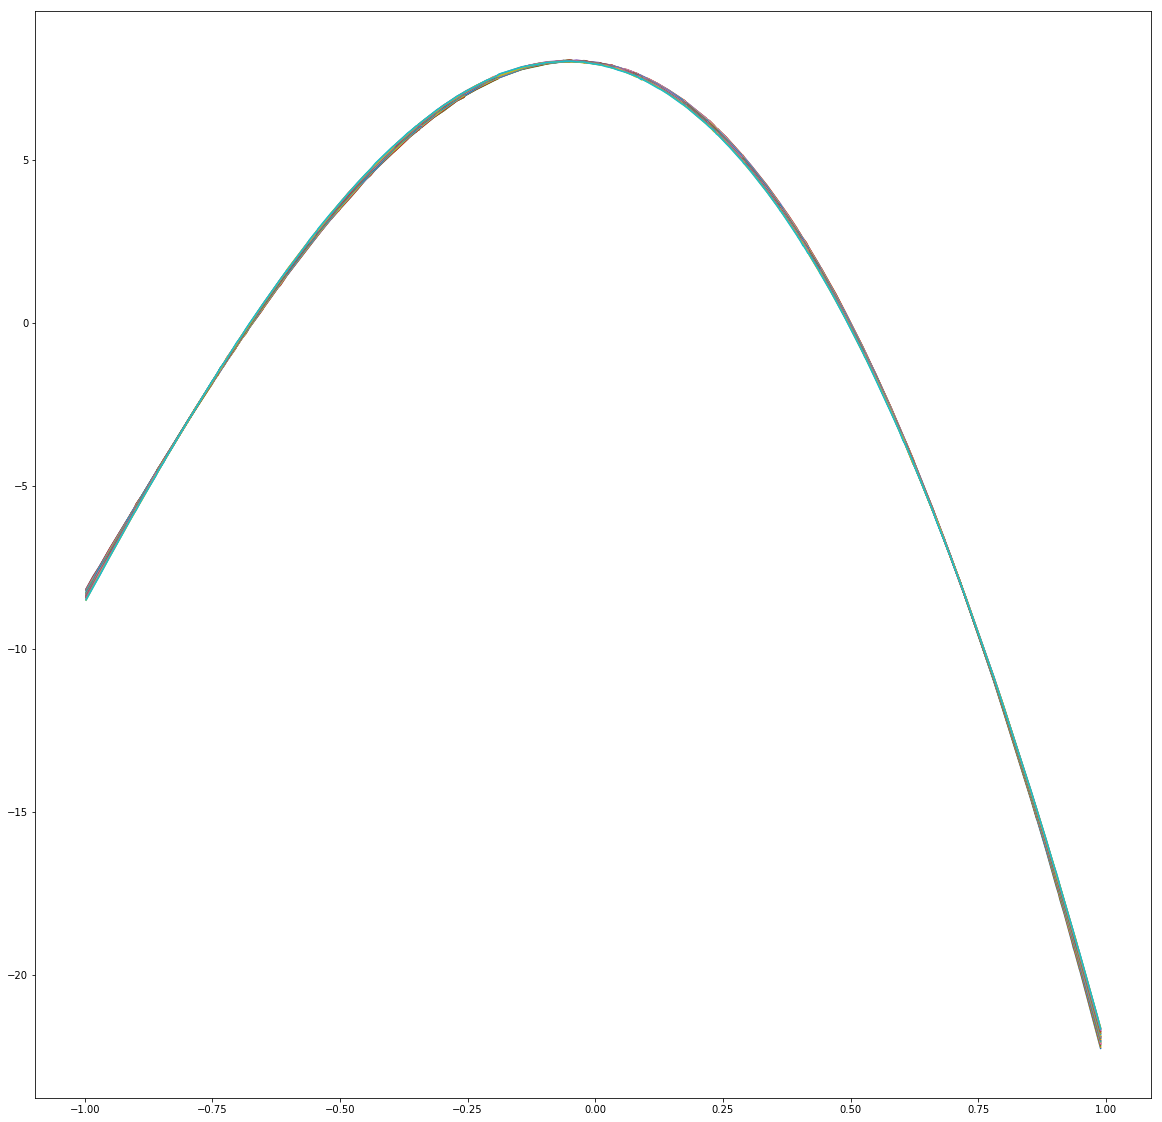

In [88]:
plt.figure(figsize=[20,20])
plt.plot(observation_index_points[::],preds.numpy()[0::10,0,:].T,'-',markersize=1,alpha=1);

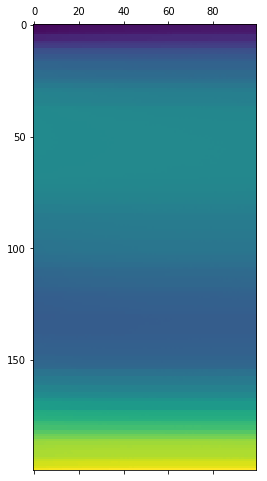

In [84]:
plt.matshow(preds.numpy()[::10,0,:].T)